Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score
)

import shap

import matplotlib.pyplot as plt
import seaborn as sns

Load Dataset

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Replace Zero Values with Mean

In [3]:
zero_cols = ["BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in zero_cols:
    mean_val = df.loc[df[col] != 0, col].mean()
    df.loc[df[col] == 0, col] = mean_val

C:\Users\alloy\AppData\Local\Temp\ipykernel_153940\3415465682.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '72.40518417462484' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == 0, col] = mean_val
C:\Users\alloy\AppData\Local\Temp\ipykernel_153940\3415465682.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.153419593345657' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == 0, col] = mean_val
C:\Users\alloy\AppData\Local\Temp\ipykernel_153940\3415465682.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '155.5482233502538' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == 0, col] = mean_val


Define Target Variable

In [4]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
print("X shape:", X.shape)

X shape: (768, 8)


Train–Test Split (80:20)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Ouput and Plotting Function

In [6]:
def print_model_report(model_name, train_acc, cv_acc_mean, y_test, y_pred, report_text):
    print(f"{model_name} Training Accuracy:   {train_acc:.4f}")
    print("\n--- Final Test Set Report ---")
    print(report_text)

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(
        cm,
        cmap="Blues",
        cbar=True,
        xticklabels=["Non-Diabetes", "Diabetes"],
        yticklabels=["Non-Diabetes", "Diabetes"],
        annot=False
    )

    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j + 0.5,
                i + 0.5,
                cm[i, j],
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold",
                color="white" if cm[i, j] > threshold else "black"
            )

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = roc_auc_score(y_true, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

    return auc_val

Feature Scaling for Logisitc Regression

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

Train Model

In [8]:
log_model = LogisticRegression(max_iter=2000, random_state=42)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000, random_state=42)

Training Accuracy + 5-Fold CV on Train set

In [9]:
train_acc_log = accuracy_score(y_train, log_model.predict(X_train_scaled))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc_log = cross_val_score(log_model, X_train_scaled, y_train, cv=cv, scoring="accuracy")
cv_auc_log = cross_val_score(log_model, X_train_scaled, y_train, cv=cv, scoring="roc_auc")

val_acc_log = cv_acc_log.mean()
val_auc_log = cv_auc_log.mean()

Test Evaluation + Output

In [10]:
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

report_log = classification_report(
    y_test, y_pred_log,
    target_names=["Non-Diabetes", "Diabetes"]
)

print_model_report(
    "Logistic Regression",
    train_acc_log,
    val_acc_log,
    y_test,
    y_pred_log,
    report_log
)

Logistic Regression Training Accuracy:   0.7866

--- Final Test Set Report ---
              precision    recall  f1-score   support

Non-Diabetes       0.75      0.80      0.78       100
    Diabetes       0.58      0.52      0.55        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



Plot Confusion Matric + ROC Curve

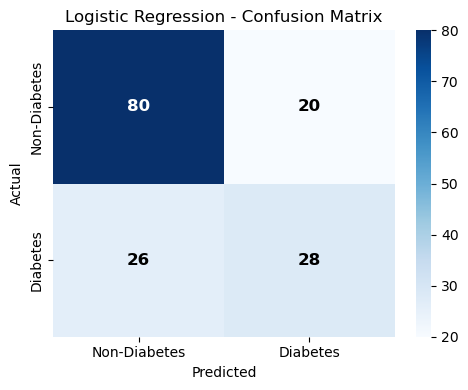

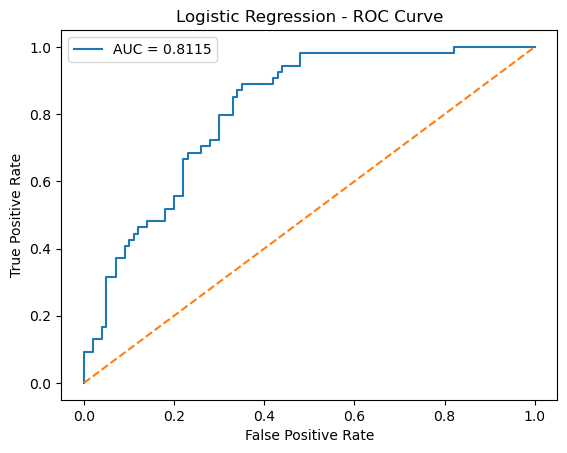

Logistic Regression CV ROC-AUC:   0.8355
Logistic Regression Test ROC-AUC: 0.8115


In [11]:
plot_confusion_matrix(
    y_test,
    y_pred_log,
    title="Logistic Regression - Confusion Matrix"
)
test_auc_log = plot_roc_curve(y_test, y_prob_log, title="Logistic Regression - ROC Curve")

print(f"Logistic Regression CV ROC-AUC:   {val_auc_log:.4f}")
print(f"Logistic Regression Test ROC-AUC: {test_auc_log:.4f}")

### Decision Tree

Train Model

In [12]:
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5
)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Training Accuracy + 5-Fold CV on Train set

In [13]:
train_acc_dt = accuracy_score(y_train, dt_model.predict(X_train))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_acc_dt = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="accuracy")
cv_auc_dt = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring="roc_auc")

val_acc_dt = cv_acc_dt.mean()
val_auc_dt = cv_auc_dt.mean()

Test Evaluation + Output

In [14]:
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

report_dt = classification_report(
    y_test, y_pred_dt,
    target_names=["Non-Diabetes", "Diabetes"]
)

print_model_report(
    "Decision Tree",
    train_acc_dt,
    val_acc_dt,
    y_test,
    y_pred_dt,
    report_dt
)


Decision Tree Training Accuracy:   0.8127

--- Final Test Set Report ---
              precision    recall  f1-score   support

Non-Diabetes       0.84      0.78      0.81       100
    Diabetes       0.64      0.72      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154



Plot Confusion Matric + ROC Curve

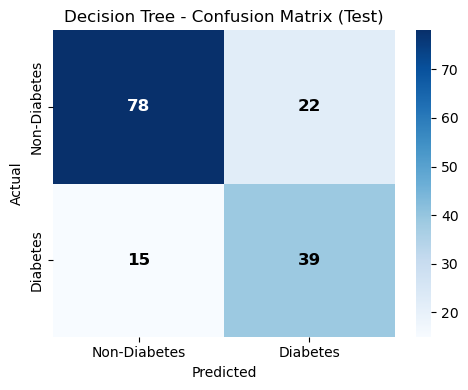

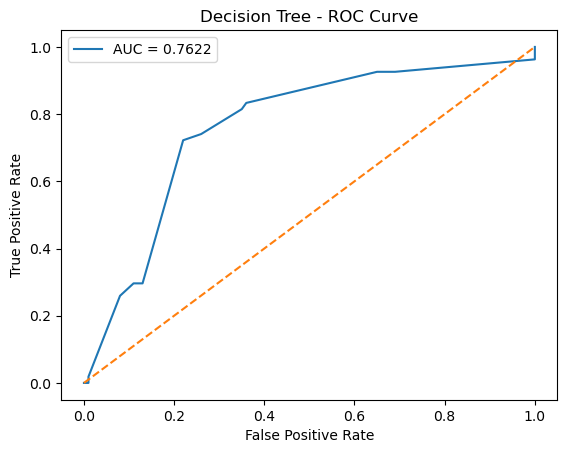

Decision Tree CV ROC-AUC:   0.7612
Decision Tree Test ROC-AUC: 0.7622


In [15]:
plot_confusion_matrix(
    y_test,
    y_pred_dt,
    title="Decision Tree - Confusion Matrix (Test)"
)

test_auc_dt = plot_roc_curve(
    y_test,
    y_prob_dt,
    title="Decision Tree - ROC Curve"
)

print(f"Decision Tree CV ROC-AUC:   {val_auc_dt:.4f}")
print(f"Decision Tree Test ROC-AUC: {test_auc_dt:.4f}")


Compute Test Metrics for Each Model

In [16]:
# Logistic Regression metrics (TEST)
test_metrics_log = {
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1-score": f1_score(y_test, y_pred_log),
    "ROC-AUC": roc_auc_score(y_test, y_prob_log)
}

# Decision Tree metrics (TEST)
test_metrics_dt = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1-score": f1_score(y_test, y_pred_dt),
    "ROC-AUC": roc_auc_score(y_test, y_prob_dt)
}


Create Comparison Table

In [17]:
comparison_df = pd.DataFrame.from_dict(
    {
        "Logistic Regression": test_metrics_log,
        "Decision Tree": test_metrics_dt
    },
    orient="index"
)

comparison_df

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression,0.701299,0.583333,0.518519,0.549020,0.811481
Decision Tree,0.759740,0.639344,0.722222,0.678261,0.762222


Select Best Model Based on TEST Accuracy

In [18]:
best_model_name = comparison_df["Accuracy"].idxmax()
print("Best Model Selected (Based on Test Accuracy):", best_model_name)

Best Model Selected (Based on Test Accuracy): Decision Tree


SHAP Evaluation on Best Model

Explanation shape: (154, 8)


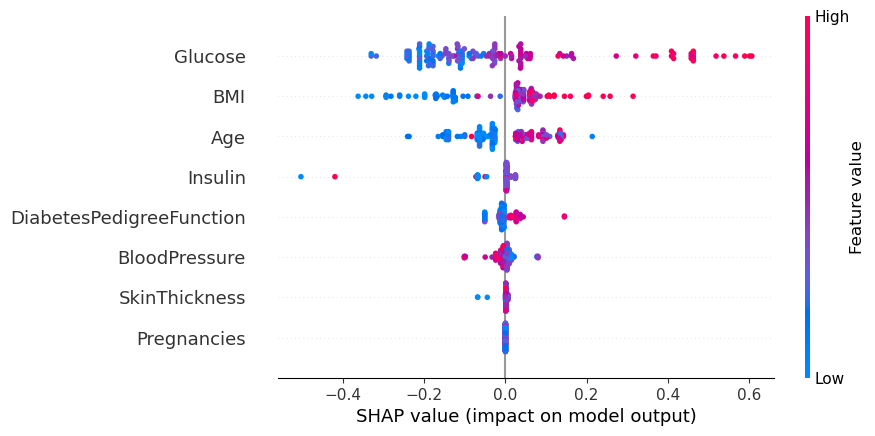

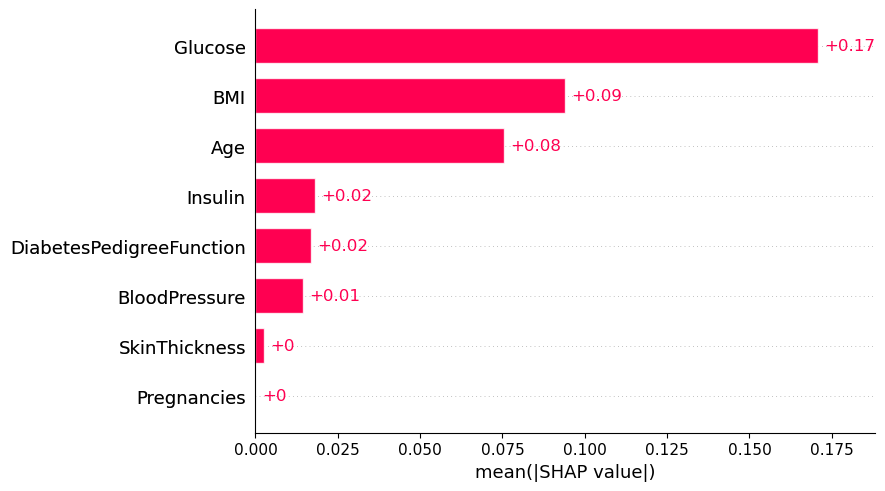

In [19]:
if best_model_name == "Decision Tree":
    feature_names = X.columns.tolist()

    # 2) Ensure X_test is a DataFrame with correct column names
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    # 3) TreeExplainer
    explainer = shap.TreeExplainer(dt_model)

    # 4) Create Explanation object
    explanation = explainer(X_test_df)

    # 5) Select class 1 (positive class = Diabetes) if Explanation is 3D
    if hasattr(explanation, "values") and np.array(explanation.values).ndim == 3:
        explanation_1 = shap.Explanation(
            values=explanation.values[:, :, 1],
            base_values=explanation.base_values[:, 1]
            if np.array(explanation.base_values).ndim == 2 else explanation.base_values,
            data=explanation.data,
            feature_names=explanation.feature_names
        )
    else:
        explanation_1 = explanation

    print("Explanation shape:", np.array(explanation_1.values).shape)

    # 6) Beeswarm (ALL features)
    shap.plots.beeswarm(explanation_1, max_display=len(feature_names))

    # 7) Bar plot (ALL features)
    shap.plots.bar(explanation_1, max_display=len(feature_names))